In [3]:
from igraph import *
import cairo

import numpy as np
import pandas as pd
import random

In [4]:
import tensorflow as tf
from tensorflow import keras

print(tf.__version__)

1.13.1


In [5]:
import matplotlib.pyplot as plt

In [6]:
from PIL import Image

In [7]:
np.set_printoptions(precision=3, suppress=True)

In [8]:
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import classification_report, precision_recall_curve, average_precision_score
from sklearn.utils.fixes import signature

In [9]:
import itertools

In [10]:
!wc -l trimmed_dataset/tx.edgelist

65715613 trimmed_dataset/tx.edgelist


# Reading graph

In [11]:
g = Graph()
g = Graph.Read_Ncol('trimmed_dataset/tx.edgelist', directed=True)
g.es['weight'] = np.around(g.es['weight'], decimals=2)
g.summary()

'IGRAPH DNW- 30010551 65715613 -- \n+ attr: name (v), weight (e)'

In [12]:
g.vs['risk'] = 0

In [13]:
def create_tx_tree(txID, bbox=(800, 1200), depth=6, image_mode=False):
    vs = []
    
    def bfs_tree_sg(idx, curr_depth=0, MAX_DEPTH=3):
        if curr_depth > MAX_DEPTH: return

        src = g.vs[idx]

        if curr_depth == 0: 
            vs.append(idx)

        for dest in src.neighbors(mode='OUT'):
            vs.append(dest.index)
            bfs_tree_sg(dest.index, curr_depth+1, MAX_DEPTH)
            
    bfs_tree_sg(g.vs.find(str(txID)).index, MAX_DEPTH=depth)

    sg = g.induced_subgraph(vs, implementation="create_from_scratch")
    layout = sg.layout('rt', root=[0])
    layout.rotate(-90)

    styles = {
        "vertex_size": 40,
        "vertex_color": "white",
        "margin": 40,
        "bbox": bbox,
        "vertex_label": [a + "\n(" + str(round(b, 4)) + ")" for a, b in zip(sg.vs['name'], sg.vs['risk'])], 
        "vertex_label_size": 8, 
        "vertex_label_color": "red",
        "edge_label": sg.es['weight'], 
        "edge_label_size": 10,
        "edge_label_color": "green",
        "edge_label_distance": 1,
        "edge_opacity": 0.4,
        "edge_curved": 0.1,
        "edge_width": [1 if x < 2 else math.log(x, 2)  for x in sg.es['weight']],  
    }

    if image_mode:
        out = plot(sg, layout=layout, **styles)
        _filepath = "igraph_plots/" + str(txID) + ".jpg"
        out.save(_filepath)
        return Image.open(_filepath)
    else:
        return plot(sg, layout=layout, **styles)

# Risk-scoring transactions

In [14]:
flagged_df = pd.read_csv('trimmed_dataset/tx_flagged.txt', delimiter='\t', names=['txID', 'txhash'])
flagged_df.head()

,txID,txhash
0,101661,EB5B761C7380ED4C6ADF688F9E5AB94953DCABEDA47D9E...
1,718648,4885DDF124A0F97B5A3775A12DE0274D342D12842EBE59...
2,2529787,5A09F4EF0E91BC7BC044365CD27236FE4AC3C02088AC21...
3,2529781,7B45C1742CA9F544CCCD92D319EF8A5E19B7DCB8742990...
4,2529783,901DBCEF30A541B8B55FAE8F7AD9917EF0754BDA5B6437...


In [15]:
flagged = np.random.choice(list(flagged_df['txID']), size=40, replace=False)

In [16]:
flagged_df[~flagged_df.txID.isin(flagged)]

,txID,txhash
3,2529781,7B45C1742CA9F544CCCD92D319EF8A5E19B7DCB8742990...
10,2529773,14350F6F2BDA8F4220F5B5E11022AB126A4B178E5C4FCA...
17,6719706,83F3C30DC4FA25AFE57B85651B9BBC372E8789D81B08D6...
18,6720088,D5D23A05858236C379D2AA30886B97600506933BC46C6F...
21,6720176,42EA472060118EE5AEE801CDEDBC4A3403F3708A873406...
23,7495626,8E6A2D0B8132D3D9EDC1FCFFE1B3079DE59C10C67522E2...
31,8257853,0AE924C33555B294A3F0B256DA6A02AB996D30BE00EAF1...
35,8678426,C041A74FD565C3EB247FF4B1FB6EB0AB9299C3E7D58E51...
39,8915883,3A66EBEF43041F230E799F1EFD3A93E41F875C718DA683...


In [17]:
non_flagged = list(flagged_df[~flagged_df.txID.isin(flagged)].txID)

In [18]:
non_flagged

[2529781,
 2529773,
 6719706,
 6720088,
 6720176,
 7495626,
 8257853,
 8678426,
 8915883]

In [19]:
def risk_score(tx_idx, risk, STOP_VALUE=0.01):    
    
    src = g.vs[tx_idx]
    # print(src['name'], round(risk, 5))
    g.vs[tx_idx]['risk'] += risk
    
    if risk <= STOP_VALUE: return
    
    outs = [g.es[g.get_eid(src.index, dest.index)]['weight'] for dest in src.neighbors(mode='OUT')]
    total_out = np.sum(outs)
    
    for i, dest in enumerate(src.neighbors(mode='OUT')):
        risk_score(dest.index, risk*outs[i]/total_out)
        
g.vs['risk'] = 0

for i in range(10):
    random.shuffle(flagged)
    for txID in flagged:
        risk_score(g.vs.find(str(txID)).index, 1.0)

g.vs['risk'] = np.nan_to_num(np.around(np.multiply(g.vs['risk'], 1/10), 3), 0)

/home/nyuad/Documents/capstone/venv/lib/python3.5/site-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in double_scalars
  del sys.path[0]


In [20]:
risks_ar = np.array(g.vs['risk'])

(array([1520.,  390.,  241.,   78.,   55.,   52.,   25.,   24.,   53.,
          73.,   15.,   18.,   34.,   12.,   13.,   25.,   15.,   20.,
           9.,    3.,    0.,    4.,    2.,    3.,    3.,    0.,    0.,
           1.,    3.,    8.,    4.,    5.,    0.,    2.,    5.,    0.,
           0.,    1.,    3.,    4.,    1.,    1.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    1.,    1.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.]),
 array([ 0.1,  0.2,  0.3,  0.4,  0.5,  0.6,  0.7,  0.8,  0.9,  1. ,  1.1,
         1.2,  1.3,  1.4,  1.5,  1.6,  1.7,  1.8,  1.9,  2. ,  2.1,  2.2,
         2.3,  2.4,  2.5,  2.6,  2.7,  2.8,  2.9,  3. ,  3.1,  3.2,  

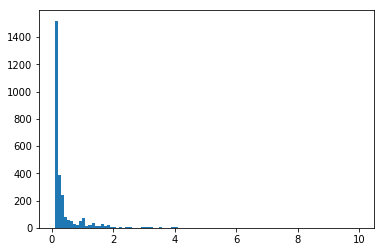

In [21]:
plt.hist(risks_ar, bins=99, range=(0.1, 10))

In [22]:
np.count_nonzero(risks_ar), np.count_nonzero(risks_ar)/len(g.vs)*100

(15709, 0.052344923623694875)

### Computing tx features

Based on the measured variable provided by the Bitcoin network, we attempt to build more meaningful features that will assist our learning algorithm in terms attaining the desired objectives. A total of 14 features were derived from the transaction data of the Bitcoin network. The following 14 features were derived from the dataset:

- Currency features: total amount sent, total amount received, average amount sent, average amount received, standard deviation received, standard deviation sent

- Network Features: in degree, out degree, clustering coefficient, number of triangles,

- Average neighbourhood (source target) whereby with reference to each query node: source refers to origin on incoming transaction and target is the destination. The four features identified: in-in, in-out, out-out, out-in.

In [23]:
features_df = pd.read_csv('trimmed_dataset/tx_features.csv').set_index('txID')
features_df.head()

,in_degree,out_degree,avg_recv,avg_sent,median_recv,median_sent,stdev_recv,stdev_sent
txID,,,,,,,,
9,0,1,0.0,50.0,0.0,50.0,0.0,0.0
78,0,1,0.0,50.0,0.0,50.0,0.0,0.0
171,1,2,50.0,25.0,50.0,25.0,0.0,15.0
183,1,1,40.0,30.0,40.0,30.0,0.0,0.0
185,1,2,30.0,15.0,30.0,15.0,0.0,14.0


In [24]:
len(features_df)

30010551

## Random walk

In [25]:
g.vs[flagged[10]]

igraph.Vertex(<igraph.Graph object at 0x7ffa1e8da408>, 8915880, {'name': '8957001', 'risk': 0.0})

In [26]:
# Biased random walk
def random_walk(g, start_idx, uniform=False, curr_length=0, length=8):
    if curr_length >= length:
        return []
    
    src = g.vs[start_idx]
    
    neighbors = [dest.index for dest in src.neighbors(mode="OUT")]
    risks = [math.log(dest['risk']+4, 2) for dest in src.neighbors(mode="OUT")]
    total_risk = np.sum(risks)
    
    if total_risk == 0 or uniform == True:
        probabilities = [1/len(risks) for r in risks] # uniform
    else:
        probabilities = [r/total_risk for r in risks] # biased
        
    if len(neighbors) == 0:
        return []
    
    # return src['name'] + " (" + str(round(src['risk'], 2)) + ")\n" + random_walk(g, np.random.choice(neighbors, size=1, p=probabilities)[0], curr_length+1, length)
    return [round(src['risk'], 2)] + random_walk(g, np.random.choice(neighbors, size=1, p=probabilities)[0], uniform, curr_length+1, length)

for i in range(10):
    outs = random_walk(g, 67156, True, 0, 10)
    print("\t".join([str(x) for x in outs]), np.around(np.sum(outs), 2), sep="\t| ")

0.99	0.99	0.23	0.2	0.2	0.18	0.18	0.03	0.0	0.0	| 3.0
0.99	0.99	0.76	0.76	0.76	0.76	0.76	0.68	0.0	0.0	| 6.46
0.99	0.99	0.76	0.76	0.76	0.76	0.76	0.68	0.68	0.68	| 7.82
0.99	0.99	0.76	0.76	0.76	0.76	0.76	0.68	0.68	0.68	| 7.82
0.99	0.99	0.76	0.76	0.76	0.76	0.76	0.68	0.68	0.68	| 7.82
0.99	0.99	0.76	0.76	0.76	0.76	0.76	0.68	0.68	0.68	| 7.82
0.99	0.99	0.23	0.2	0.2	0.02	0.0	0.0	0.0	0.0	| 2.63
0.99	0.99	0.76	0.76	0.76	0.76	0.76	0.68	0.0	0.0	| 6.46
0.99	0.99	0.23	0.2	0.2	0.02	0.0	0.0	0.0	0.0	| 2.63
0.99	0.99	0.23	0.2	0.2	0.02	0.0	0.0	0.0	0.0	| 2.63


In [27]:
def vec_to_features(vec):
    _tmp = np.array([features_df.loc[int(g.vs[i]['name'])].values for i in vec]).ravel()
    return list(np.pad(_tmp, (0, 64-len(_tmp)), mode='constant')) + [np.sum(risks_ar.take(vec))]

In [28]:
# Biased random walk
def random_walk_vec(g, start_idx, uniform=True, curr_length=0, MAX_LENGTH=8):
    if curr_length >= MAX_LENGTH:
        return []
    
    src = g.vs[start_idx]
    
    neighbors = [dest.index for dest in src.neighbors(mode="OUT")]
    risks = [math.log(dest['risk']+4, 2) for dest in src.neighbors(mode="OUT")]
    total_risk = np.sum(risks)
    
    if total_risk == 0 or uniform == True:
        probabilities = [1/len(risks) for r in risks] # uniform
    else:
        probabilities = [r/total_risk for r in risks] # biased
        
    if len(neighbors) == 0:
        return []
    
    # return src['name'] + " (" + str(round(src['risk'], 2)) + ")\n" + random_walk(g, np.random.choice(neighbors, size=1, p=probabilities)[0], curr_length+1, length)
    return [src.index] + random_walk_vec(g, np.random.choice(neighbors, size=1, p=probabilities)[0], uniform, curr_length+1)

def generate_vecs(index, N=10, uniform=True):
    _lvecs = []
    for _ in range(N):
        _lvecs.append(vec_to_features(random_walk_vec(g, index, uniform, 0)))
      
    return _lvecs

In [29]:
np.array(generate_vecs(67156))

array([[    15.   ,      1.   ,     86.667,   1300.   ,      5.89 ,
          1300.   ,    245.527,      0.   ,      1.   ,      2.   ,
          1300.   ,    650.   ,   1300.   ,    650.   ,      0.   ,
           350.   ,      1.   ,      1.   ,   1000.   ,   1000.   ,
          1000.   ,   1000.   ,      0.   ,      0.   ,      1.   ,
             1.   ,   1000.   ,   1000.   ,   1000.   ,   1000.   ,
             0.   ,      0.   ,      1.   ,      1.   ,   1000.   ,
          1000.   ,   1000.   ,   1000.   ,      0.   ,      0.   ,
             1.   ,      2.   ,   1000.   ,    500.   ,   1000.   ,
           500.   ,      0.   ,    341.3  ,      2.   ,      2.   ,
           500.   ,    500.   ,    500.   ,    500.   ,    341.3  ,
           327.71 ,      4.   ,      2.   ,    500.   ,   1000.   ,
           500.   ,   1000.   ,    333.535,    995.55 ,      6.475],
       [    15.   ,      1.   ,     86.667,   1300.   ,      5.89 ,
          1300.   ,    245.527,      0.   ,    

## Training and test sequences (Synthetic dataset)

In [30]:
flagged = np.flatnonzero(risks_ar >= 0.01)
flagged.shape

(12676,)

In [31]:
A_samples = set(np.random.choice(len(g.vs), size=len(flagged), replace=False)) - set(flagged)
%time A = np.array([vec for x in A_samples for vec in generate_vecs(x)])

CPU times: user 5min 50s, sys: 381 ms, total: 5min 50s
Wall time: 5min 50s


In [32]:
B_samples = np.random.choice(flagged, size=len(flagged), replace=False)
%time B = np.array([vec for x in B_samples for vec in generate_vecs(x)])

CPU times: user 5min 45s, sys: 357 ms, total: 5min 45s
Wall time: 5min 45s


In [33]:
A.shape

(126670, 65)

In [34]:
B.shape

(126760, 65)

In [35]:
X = np.concatenate((A[:, :64], B[:, :64]))
Y = np.concatenate((A[:, 64], B[:, 64]))
y = np.array(Y>=0.1).astype('int')

In [36]:
X.shape, Y.shape

((253430, 64), (253430,))

In [37]:
np.count_nonzero(y), np.count_nonzero(y)/len(y)

(126784, 0.5002722645306397)

In [38]:
_ps = (y+1)**0
samples = np.random.choice(X.shape[0], size=X.shape[0], replace=False, p=np.divide(_ps, np.sum(_ps)))

In [39]:
X_train, X_test, y_train, y_test = train_test_split(X[samples], y[samples])

In [40]:
np.count_nonzero(y_train)/len(y_train)

0.5006944736731344

In [41]:
np.count_nonzero(y_test)/len(y_test)

0.4990056504308848

In [42]:
model = keras.Sequential([
    keras.layers.Dense(128, activation=tf.nn.relu),
    keras.layers.Dense(64, activation=tf.nn.relu),
    keras.layers.Dense(32, activation=tf.nn.relu),
    keras.layers.Dense(2, activation=tf.nn.softmax)
])

In [43]:
model.compile(optimizer='adam', 
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

Instructions for updating:
Colocations handled automatically by placer.


In [44]:
model.fit(X_train, y_train, validation_split=0.2, epochs=10)

Train on 152057 samples, validate on 38015 samples
Epoch 1/10
152057/152057 [==============================] - 11s 71us/sample - loss: 0.8951 - acc: 0.8614 - val_loss: 0.3151 - val_acc: 0.8849
Epoch 2/10
152057/152057 [==============================] - 10s 68us/sample - loss: 0.3354 - acc: 0.8782 - val_loss: 0.3112 - val_acc: 0.8787
Epoch 3/10
152057/152057 [==============================] - 10s 68us/sample - loss: 0.3159 - acc: 0.8811 - val_loss: 0.2961 - val_acc: 0.8890
Epoch 4/10
152057/152057 [==============================] - 10s 68us/sample - loss: 0.3104 - acc: 0.8743 - val_loss: 0.2832 - val_acc: 0.8845
Epoch 5/10
152057/152057 [==============================] - 10s 68us/sample - loss: 0.3051 - acc: 0.8789 - val_loss: 0.3121 - val_acc: 0.8649
Epoch 6/10
152057/152057 [==============================] - 10s 68us/sample - loss: 0.2909 - acc: 0.8815 - val_loss: 0.2696 - val_acc: 0.8832
Epoch 7/10
152057/152057 [==============================] - 10s 68us/sample - loss: 0.2846 - acc:

In [45]:
test_loss, test_acc = model.evaluate(X_test, y_test)
print('Test accuracy:', test_acc)

63358/63358 [==============================] - 2s 26us/sample - loss: 0.2955 - acc: 0.8971
Test accuracy: 0.8971243


In [46]:
y_pred = model.predict(X_test)
y_pred_bool = np.argmax(y_pred, axis=1)

print(classification_report(y_test, y_pred_bool))

              precision    recall  f1-score   support

           0       0.92      0.87      0.89     31742
           1       0.88      0.92      0.90     31616

   micro avg       0.90      0.90      0.90     63358
   macro avg       0.90      0.90      0.90     63358
weighted avg       0.90      0.90      0.90     63358



In [47]:
# fix random seed for reproducibility
seed = 7
np.random.seed(seed)

# define 10-fold cross validation test harness
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=seed)

cvscores = []
for train, test in kfold.split(X, y):
    # create model
    model = keras.Sequential([
        keras.layers.Dense(128, activation=tf.nn.relu),
        keras.layers.Dense(64, activation=tf.nn.relu),
        keras.layers.Dense(32, activation=tf.nn.relu),
        keras.layers.Dense(2, activation=tf.nn.softmax)
    ])
    # Compile model
    model.compile(optimizer='adam', 
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy'])
    # Fit the model
    model.fit(X[train], y[train], validation_split=0.2, epochs=10, verbose=0)
    # evaluate the model
    scores = model.evaluate(X[test], y[test], verbose=0)
    print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))
    cvscores.append(scores[1] * 100)
    
    y_pred = model.predict(X[test])
    y_pred_bool = np.argmax(y_pred, axis=1)
    
    print(classification_report(y[test], y_pred_bool))

print("%.2f%% (+/- %.2f%%)" % (np.mean(cvscores), np.std(cvscores)))

acc: 90.29%
              precision    recall  f1-score   support

           0       0.88      0.94      0.91     12665
           1       0.93      0.87      0.90     12679

   micro avg       0.90      0.90      0.90     25344
   macro avg       0.90      0.90      0.90     25344
weighted avg       0.90      0.90      0.90     25344

acc: 90.01%
              precision    recall  f1-score   support

           0       0.87      0.94      0.90     12665
           1       0.93      0.86      0.90     12679

   micro avg       0.90      0.90      0.90     25344
   macro avg       0.90      0.90      0.90     25344
weighted avg       0.90      0.90      0.90     25344

acc: 90.38%
              precision    recall  f1-score   support

           0       0.89      0.92      0.91     12665
           1       0.92      0.89      0.90     12679

   micro avg       0.90      0.90      0.90     25344
   macro avg       0.90      0.90      0.90     25344
weighted avg       0.90      0.90     

In [48]:
print("%.2f%% (+/- %.2f%%)" % (np.mean(cvscores), np.std(cvscores)))

89.64% (+/- 1.06%)


### Original test dataset

In [92]:
%time C = np.array([[x] + vec for x in non_flagged for vec in generate_vecs(g.vs.find(str(x)).index )])
%time D = np.array([[x] + vec for x in list(set(np.random.choice(len(g.vs), size=90, replace=False))-set(flagged)) for vec in generate_vecs(g.vs.find(str(x)).index)])

CPU times: user 370 ms, sys: 61.1 ms, total: 431 ms
Wall time: 2.35 s
CPU times: user 6.65 s, sys: 1.14 s, total: 7.79 s
Wall time: 2min 6s


In [93]:
C.shape

(90, 66)

In [94]:
D.shape

(900, 66)

In [95]:
non_flagged

[2529781,
 2529773,
 6719706,
 6720088,
 6720176,
 7495626,
 8257853,
 8678426,
 8915883]

In [96]:
_X = np.concatenate((C[:, :65], D[:, :65]))
_y = np.concatenate((np.ones(C.shape[0]), np.array(D[:, 65]>=0.01).astype('int')))

In [99]:
for txID in non_flagged:
    print("\t".join([str(x) for x in np.around(np.array(generate_vecs(g.vs.find(str(txID)).index))[:, 64], 2)]))

3.05	0.02	0.53	0.09	0.06	0.06	8.46	3.17	0.09	0.02
0.0	0.0	2.01	0.0	5.75	0.76	2.01	0.0	4.69	0.0
0.0	0.0	0.66	0.66	0.95	0.66	0.0	0.44	0.0	0.66
0.85	1.58	0.0	0.0	0.0	5.88	2.42	5.88	0.0	0.0
0.0	0.0	3.65	6.92	8.59	0.0	0.0	0.0	0.0	0.0
3.23	1.18	0.86	0.86	1.0	5.06	1.0	1.0	0.86	1.19
0.0	0.0	13.32	2.92	0.0	0.0	0.0	0.0	22.68	0.0
0.0	15.18	13.7	0.0	0.0	0.0	0.0	12.32	12.3	4.77
0.0	0.46	0.46	0.0	0.0	1.68	1.68	0.46	1.68	0.46


In [100]:
y_pred_original = model.predict(_X[:, 1:65])
y_pred_original_bool = np.argmax(y_pred_original, axis=1)

In [101]:
__y = [np.rint(np.mean(l)) for l in _y.reshape(len(set(_X[:, 0])), 10)]
__y_pred_original_bool = [np.rint(np.mean(l)) for l in y_pred_original_bool.reshape(len(set(_X[:, 0])), 10)]
print(classification_report(__y, __y_pred_original_bool))

              precision    recall  f1-score   support

         0.0       0.95      0.93      0.94        90
         1.0       0.45      0.56      0.50         9

   micro avg       0.90      0.90      0.90        99
   macro avg       0.70      0.74      0.72        99
weighted avg       0.91      0.90      0.90        99



(array([90.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  9.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

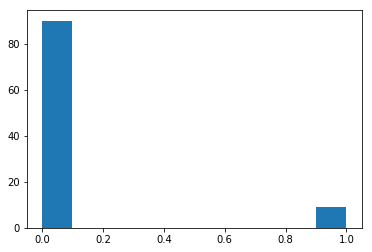

In [112]:
plt.hist(__y)

In [102]:
np.count_nonzero(__y_pred_original_bool[:9])

5

In [103]:
np.count_nonzero(__y_pred_original_bool)

11

(array([81.,  3.,  2.,  0.,  1.,  2.,  3.,  0.,  1.,  6.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

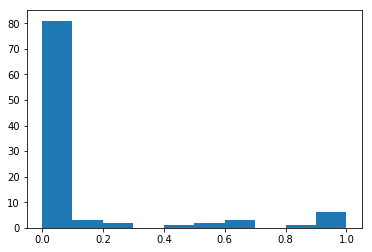

In [104]:
plt.hist([np.mean(l) for l in y_pred_original_bool.reshape((len(set(_X[:, 0])), 10))])

In [105]:
np.count_nonzero(y_pred_original_bool), len(y_pred_original_bool)

(110, 990)

In [107]:
list(zip(np.array(non_flagged).astype('int'), __y_pred_original_bool[:9]))

[(2529781, 1.0),
 (2529773, 0.0),
 (6719706, 1.0),
 (6720088, 1.0),
 (6720176, 1.0),
 (7495626, 1.0),
 (8257853, 0.0),
 (8678426, 0.0),
 (8915883, 0.0)]

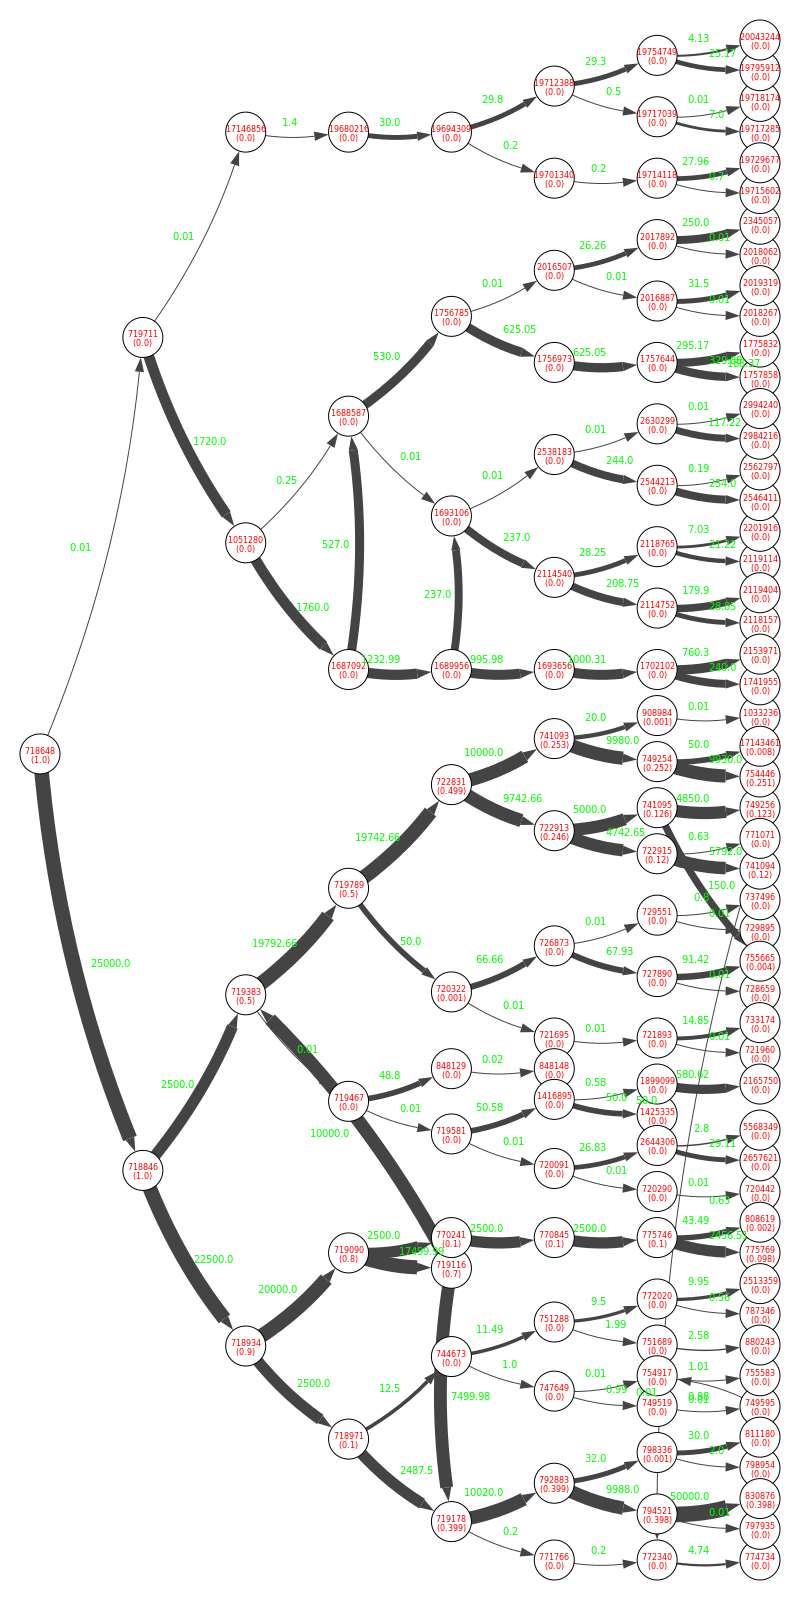

In [137]:
create_tx_tree('718648', image_mode=True, depth=6, bbox=(800, 1600))